In [1]:
filename = 'lakeside.jpeg'

In [2]:
from copy import deepcopy
import torch
from torchvision.models import resnet18
model = resnet18(pretrained=True)
model.eval()

/home/adamwsl/miniconda3/envs/male/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adamwsl/miniconda3/envs/male/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [4]:
from PIL import Image
from torchvision import transforms
input_image = Image.open(filename)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [5]:
import cv2
import numpy as np
image_center_resized = input_tensor.numpy()
image_center_resized = np.transpose(image_center_resized, (1, 2, 0))
#image_center_resized = cv2.resize(image_center_resized, (256, 256))
#x = 256 - 224
#x /= 2
#x = int(x)
#image_center_resized = image_center_resized[x:256-x,x:256-x,:]

In [6]:
# Read the categories
with open('imagenet_classes.txt', 'r') as f:
    categories = [s.strip() for s in f.readlines()]
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)
for i in range(top5_prob.size(0)):
    print(categories[top5_catid[i]], top5_prob[i].item())

beach wagon 0.4183421730995178
minivan 0.3140420913696289
convertible 0.07235797494649887
Model T 0.045416004955768585
jeep 0.045041777193546295


In [7]:
probabilities.argmax()

tensor(436)

In [8]:
import pandas as pd
descriptions = pd.read_csv('resnet18_imagenet.csv')
#layer_names = ['conv1'] + ['layer' + str(i) for i in range(1, 5, 1)]
layer_names = ['layer4']
'''
layer_map = {'conv1' : model.conv1, 
             'layer1' : model.layer1[0].downsample[0], 
             'layer2' : model.layer2[0].downsample[0], 
             'layer3' : model.layer3[0].downsample[0], 
             'layer4' : model.layer4[0].downsample[0]}
'''
layer_map = {'conv1' : model.bn1, 
             'layer1' : model.layer1[0].bn2, 
             'layer2' : model.layer2[0].bn2, 
             'layer3' : model.layer3[0].bn2, 
             'layer4' : model.layer4[0].bn2}

In [9]:
how_much_highest = 10

In [10]:
import numpy as np

In [11]:
from matplotlib import pyplot as plt
from captum.attr import LayerLRP, LayerActivation
from cv2 import resize
from torch import argmax, argsort, relu

per_layer_results = {layer_name : dict() for layer_name in layer_names}
per_layer_activations = deepcopy(per_layer_results)

for layer_name in layer_names:
    attribution_lrp = LayerLRP(model, layer_map[layer_name]).attribute(input_batch, argmax(probabilities))
    attribution_lrp.detach_()
    print(attribution_lrp.shape)
    attribution_lrp = relu(attribution_lrp)
    #input_batch.detach()

    sorted_ids = argsort(torch.amax(attribution_lrp, dim=(2, 3)), descending=True).squeeze_(0)
    query = descriptions[descriptions['layer'] == layer_name]
    highest_activations_query = query.iloc[sorted_ids][:how_much_highest]    
    
    attribution_activations = LayerActivation(model, layer_map[layer_name]).attribute(input_batch)

    for _, r in highest_activations_query.iterrows():
        name = r['description']
        print(r['unit'])
        viz = attribution_activations[0, r['unit'], ...].numpy()
        per_layer_results[layer_name][r['unit']] = name
        per_layer_activations[layer_name][r['unit']] = viz
        #plt.colorbar(plt.imshow(viz, cmap='jet'))
        #plt.show()

/home/adamwsl/miniconda3/envs/male/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/adamwsl/miniconda3/envs/male/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


torch.Size([1, 512, 7, 7])
445
326
140
122
179
128
427
205
167
424


In [12]:
from torchvision.models.feature_extraction import get_graph_node_names
train_nodes, eval_nodes = get_graph_node_names(model)
print(eval_nodes)

['x', 'conv1', 'bn1', 'relu', 'maxpool', 'layer1.0.conv1', 'layer1.0.bn1', 'layer1.0.relu', 'layer1.0.conv2', 'layer1.0.bn2', 'layer1.0.add', 'layer1.0.relu_1', 'layer1.1.conv1', 'layer1.1.bn1', 'layer1.1.relu', 'layer1.1.conv2', 'layer1.1.bn2', 'layer1.1.add', 'layer1.1.relu_1', 'layer2.0.conv1', 'layer2.0.bn1', 'layer2.0.relu', 'layer2.0.conv2', 'layer2.0.bn2', 'layer2.0.downsample.0', 'layer2.0.downsample.1', 'layer2.0.add', 'layer2.0.relu_1', 'layer2.1.conv1', 'layer2.1.bn1', 'layer2.1.relu', 'layer2.1.conv2', 'layer2.1.bn2', 'layer2.1.add', 'layer2.1.relu_1', 'layer3.0.conv1', 'layer3.0.bn1', 'layer3.0.relu', 'layer3.0.conv2', 'layer3.0.bn2', 'layer3.0.downsample.0', 'layer3.0.downsample.1', 'layer3.0.add', 'layer3.0.relu_1', 'layer3.1.conv1', 'layer3.1.bn1', 'layer3.1.relu', 'layer3.1.conv2', 'layer3.1.bn2', 'layer3.1.add', 'layer3.1.relu_1', 'layer4.0.conv1', 'layer4.0.bn1', 'layer4.0.relu', 'layer4.0.conv2', 'layer4.0.bn2', 'layer4.0.downsample.0', 'layer4.0.downsample.1', 'lay

In [13]:
from torchvision.models.feature_extraction import create_feature_extractor


x = torch.rand(1, 3, 224, 224)

return_nodes = {
    "layer3.1.relu_1": "layer3"
}
model2 = create_feature_extractor(model, return_nodes=return_nodes)
intermediate_outputs = model2(x)

print(intermediate_outputs['layer3'].shape)

torch.Size([1, 256, 14, 14])


In [14]:
import wikipediaapi

wiki = wikipediaapi.Wikipedia('en')
mapping = {'lakeside' : 'lake'}
if categories[top5_catid[0]] not in mapping.keys():
    page = wiki.page(categories[top5_catid[0]])
else:
    page = wiki.page(mapping[categories[top5_catid[0]]])
wiki_text = page.text

In [15]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

tokenized_wiki_text = word_tokenize(wiki_text)
tokenized_wiki_text = [w.lower() for w in tokenized_wiki_text if (not w.lower() in stop_words) and w.lower().isalpha()]

for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        tokenized_description = word_tokenize(description)
        filtered_sentence = [w.lower() for w in tokenized_description if (not w.lower() in stop_words) and w.lower().isalpha()]
        results[unit_id] = filtered_sentence

In [16]:
imagenet_banned = ['anim', 'line', 'color', 'similar', 'pattern', 'object', 'edg', 'head']

In [17]:
# importing modules
from nltk.stem import PorterStemmer
  
ps = PorterStemmer()


per_layer_results_stemmed = {layer_name : dict() for layer_name in per_layer_results.keys()}
wiki_text_stemmed = [ps.stem(w) for w in tokenized_wiki_text]
for layer_name, results in per_layer_results.items():
    for unit_id, description in results.items():
        per_layer_results_stemmed[layer_name][unit_id] = [ps.stem(w) for w in description if ps.stem(w) not in imagenet_banned]
        print(per_layer_results_stemmed[layer_name][unit_id])
        print(per_layer_results[layer_name][unit_id])
        final_og_words = list()
        for og_w in per_layer_results[layer_name][unit_id]:
            if ps.stem(og_w) in per_layer_results_stemmed[layer_name][unit_id]:
                final_og_words.append(og_w)
        print(final_og_words)
        print('#')
        per_layer_results[layer_name][unit_id] = final_og_words

[]
['animals']
[]
#
['round']
['rounded', 'objects']
['rounded']
#
['furnitur']
['furniture']
['furniture']
#
['ball', 'section']
['balls', 'sectioned', 'objects']
['balls', 'sectioned']
#
['circular']
['circular', 'objects']
['circular']
#
['ocean']
['ocean']
['ocean']
#
['vehicl']
['vehicles', 'animals']
['vehicles']
#
['black', 'white', 'stripe']
['black', 'white', 'stripes']
['black', 'white', 'stripes']
#
[]
['animals']
[]
#
['water']
['animals', 'water']
['water']
#


In [18]:
final_results = deepcopy(per_layer_results)
for ln in per_layer_results_stemmed.keys():
    for unit_id, words in per_layer_results_stemmed[ln].items():
        final_words = list()
        for i in range(len(words)):
            if words[i] in wiki_text_stemmed:
                final_words.append(per_layer_results[ln][unit_id][i])
                print(words[i])
            else:
                print('fjaoslijfjesisdo', words[i])
        if len(final_words) > 0:
            final_results[ln][unit_id] = final_words
        else:
            del final_results[ln][unit_id]
print(final_results)

fjaoslijfjesisdo round
fjaoslijfjesisdo furnitur
fjaoslijfjesisdo ball
section
fjaoslijfjesisdo circular
fjaoslijfjesisdo ocean
vehicl
fjaoslijfjesisdo black
fjaoslijfjesisdo white
fjaoslijfjesisdo stripe
water
{'layer4': {122: ['sectioned'], 427: ['vehicles'], 424: ['water']}}


In [19]:
def get_position(lv, rv, th, bh, thresh):
    positions = list()
    if np.sum(thresh[:,:lv]) > 0: positions.append('left')
    if np.sum(thresh[:,rv:]) > 0: positions.append('right')
    if np.sum(thresh[:th,:]) > 0: positions.append('top')
    if np.sum(thresh[bh:,:]) > 0: positions.append('bottom')
    if np.sum(thresh[th:bh,lv:rv]) > 0: positions.append('center')
    return positions

['sectioned']


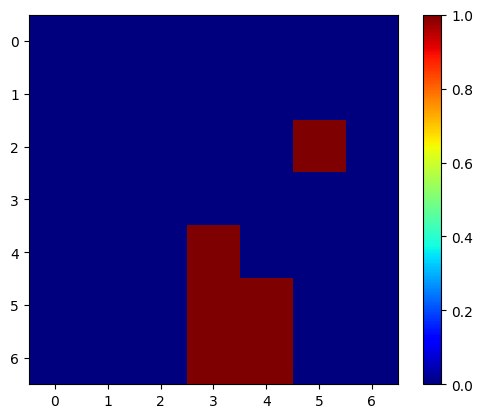

['vehicles']


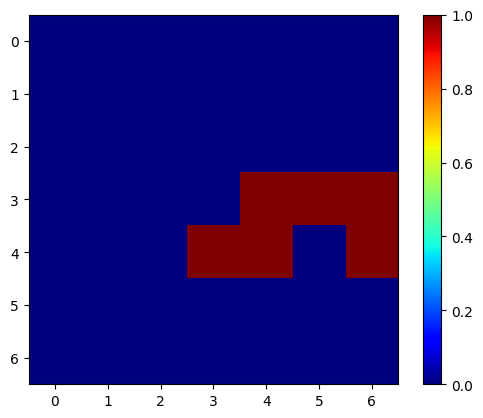

['water']


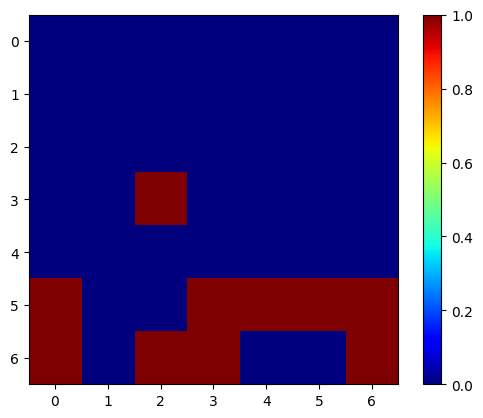

In [20]:
import cv2
per_layer_positions = deepcopy(per_layer_activations)
for ln in final_results.keys():
    for unit_id, words in final_results[ln].items():
        fm = per_layer_activations[ln][unit_id]
        _, thresh = cv2.threshold(fm, np.max(fm) * .5, np.max(fm), 0)
        thresh = cv2.normalize(thresh, None, 0, 1., cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        lv, rv = thresh.shape[0] // 3, thresh.shape[0] // 3 * 2
        th, bh = lv, rv
        per_layer_positions[ln][unit_id] = get_position(lv, rv, th, bh, thresh)
        print(final_results[ln][unit_id])
        plt.colorbar(plt.imshow(thresh, cmap='jet'))
        plt.show()

In [21]:
explanation = list()
explanation.append("The model's decision is")
explanation.append(categories[top5_catid[0]])
explanation.append('because it discovered')
for ln in final_results.keys():
    for unit_id in final_results[ln].keys():
        if len(final_results[ln][unit_id]) > 1:
            for word in final_results[ln][unit_id]:
                explanation.append(word)
                explanation.append('and')
            del explanation[-1]
        else:
            explanation.append(final_results[ln][unit_id][0])
        explanation.append(f'at the')
        if len(per_layer_positions[ln][unit_id]) > 1:
            for pos in per_layer_positions[ln][unit_id]:
                explanation.append(pos)
                explanation.append(',')
            del explanation[-1]
            del explanation[-2]
            explanation.insert(-1, 'and the')
        else:
            explanation.append(per_layer_positions[ln][unit_id][0])
        explanation.append('of the image')
        explanation.append(f'({ln} neuron number {unit_id})')
        if len(final_results[ln].keys()) > 1:
            explanation.append(', \n')
if ',' in explanation[-1]: 
    del explanation[-1]
explanation.append('.')
print(' '.join(explanation))
        

The model's decision is beach wagon because it discovered sectioned at the right and the bottom of the image (layer4 neuron number 122) , 
 vehicles at the right and the bottom of the image (layer4 neuron number 427) , 
 water at the left , right , bottom and the center of the image (layer4 neuron number 424) .


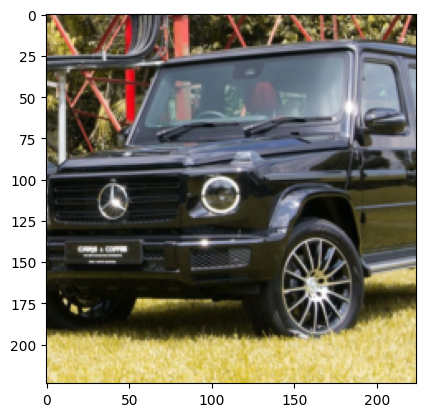

In [22]:
plt.imshow(image_center_resized)
plt.show()

In [23]:
def get_activation(layer, input_tensor):
    activations = []

    def hook(module, input, output):
        activations.append(output)

    handle = layer.register_forward_hook(hook)
    model(input_tensor)
    handle.remove()

    return activations[0]

In [24]:
from typing import List
def associate_channels(input_batch: torch.Tensor, 
                       prev_layer: torch.nn.modules.Conv2d, 
                       prev_out_channels: int,
                       curr_layer: torch.nn.modules.Conv2d, 
                       target_ch_id: int) -> List[int]:
    with torch.no_grad():
        # Get activations of both layers given an input_batch
        activations_curr = get_activation(curr_layer, input_batch)
        activations_curr = activations_curr[:,target_ch_id,:,:]
        activations_prev = get_activation(prev_layer, input_batch)
        
        # Initialize empty placeholder for contributions
        contributions = torch.empty(size=(prev_out_channels,), 
                                    device=input_batch.device)
        
        # Iterate through the channels in the prev_layer
        for ch_id in range(prev_out_channels):
            # Zero out one channel in prev_layer activation tensor
            zeroed_activations_prev = activations_prev.clone()
            zeroed_activations_prev[:,ch_id,:,:] = 0.
                    
            # Compute activation of curr_layer given zeroed out prev_layer
            from_zeroed_activations_curr = curr_layer.forward(zeroed_activations_prev)
            from_zeroed_activations_curr = from_zeroed_activations_curr[:,target_ch_id,:,:]
            
            # Compute the channel score by computing the absolute value of
            # difference between the original output and zeroed out output
            diff = torch.abs(activations_curr - from_zeroed_activations_curr)
            contributions[ch_id] = torch.sum(diff)
        
    return contributions


In [28]:
x = associate_channels(input_batch=input_batch, 
                   prev_layer=model.layer3, 
                   prev_out_channels=256,
                   curr_layer=model.layer4, 
                   target_ch_id=427)

In [29]:
torch.argsort(x)

tensor([137, 149, 211, 170, 229, 128,  44, 195, 113,   8, 141,  16,  74, 127,
        213,  81,  51,  34,  36, 226, 172, 222, 189, 106, 185, 214, 151,   2,
         66, 232,  58, 201, 116, 242,  39, 223,  26, 205,   0, 145, 134, 171,
        157, 114,  76,   4, 218, 121, 175, 148, 112, 147,  49, 167,  43, 219,
        251, 124,  78, 253,  87, 178, 100, 191, 210, 227, 224,  90, 187,  79,
        131, 105, 182,  31, 135,  27, 117, 139,  71, 108, 168,  40, 249, 246,
         48, 143, 125, 237,  84,  50, 204, 160, 123, 203,  53,  62,  92, 107,
        102, 236, 181,   9,  17, 183, 115, 165, 177,  41, 215, 136, 153, 161,
         64,  95, 200,  38, 122, 184,  80,  37, 193,   6, 245, 225, 179, 126,
          3, 154, 169, 138,  30, 241, 234, 140, 174, 109,  54,  86, 239, 231,
         63, 155,   1, 255,  96, 209, 118,  83, 176,  11,  77,  88, 190, 228,
         46,  14, 208,  42, 240,  15, 238, 244, 110,   7, 144,  56,  93,  75,
        230, 150, 221, 101, 162, 166,  72,  47,  29, 206, 194, 1

<BarContainer object of 256 artists>

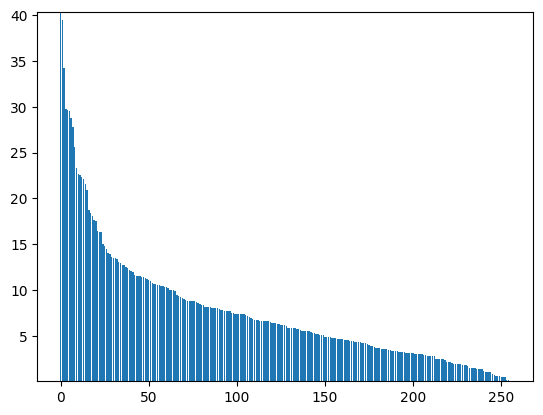

In [30]:
import matplotlib.pyplot as plt
y = list(x)
y.sort(reverse=True)
plt.ylim(min(y), max(y))
plt.bar(range(len(y)), y)